Before running the import statements below, you need to build the Cython Kepler radial velocity model found in `kepler.pyx`.  You will need to have Cython installed, and then run the following in this directory:

    python setup.py build_ext --inplace
    
This will build the necessary native-code libraries to implement the Kepler model.

In [70]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import corner
import correlated_likelihood as cl
from daft import PGM, Node, Plate
from IPython import display
import kombine
import os
import pickle
import rv_model as rv
import seaborn as sns

sns.set_style('ticks')
sns.set_context('paper')
sns.set_palette('colorblind')

# Make the font match the document
params = {'axes.labelsize': 10,
          'axes.titlesize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': True}

# Figure out figure size to avoid rescaling in the document
column_width = 246.0
inches_per_pt = 1.0/72.27
fig_width = column_width * inches_per_pt
params['figure.figsize'] = (fig_width, fig_width)
plt.rcParams.update(params)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Here are a few $\LaTeX$ macros (you won't see anything below, but they are defined once the cell is run):
$$
\newcommand{\mpers}{\mathrm{m}/\mathrm{s}}
$$

Here is an example using Kombine to fit synthetic planetary RV data.  We use the following model to generate and also fit the data.  First, the true RV amplitude involves a coherent component from the stellar recoil from a single planet plus a stochastic component, here represented by a Gaussian process with a squared-exponential correlation kernel in time.  Then the measured RV signal is normally distributed about the true RV with zero offset and standard deviation equal to the measurement uncertainty (which is assumed known).  The graphical model appears below, and the code is in `correlated_likelihood.py`.

Below $\theta$ represents the orbital parameters.  We use a parameterisation of the orbit that gives Kepler RVs (see, for example, [Gregory (2005)](http://adsabs.harvard.edu/cgi-bin/nph-data_query?bibcode=2005ApJ...631.1198G&link_type=ABSTRACT))
$$
v = \mu + K \left( \cos \left( \theta(t_i + \chi P) + \omega \right) + e \cos \omega \right),
$$
where $\mu$ is a constant velocity offset, $K$ is the velocity amplitude, $\theta(t)$ gives the true anomaly (angle from pericentre) of the orbit as a function of time, $\chi$ gives the fraction of the orbital period since the last pericentre at $t = 0$, $\omega$ is the argument of pericentre, and $e$ is the eccentricity.  So, 
$$
\theta = \left\{\mu, K, e, \omega, \chi, P \right\}.
$$

We add to this coherent velocity signal a stochastic component, represented by a Gaussian process with squared exponential kernel with scale $\tau$ and amplitude $\sigma$:
$$
\left\langle v\left(t_i\right) v\left(t_j \right) \right\rangle \sim \sigma^2 \exp\left[ - \frac{1}{2} \left( \frac{t_i - t_i}{\tau} \right)^2 \right]
$$

Finally, we introduce an overall scale factor for the measurement errors, $\nu$, that scales the quoted measurement uncertainty.

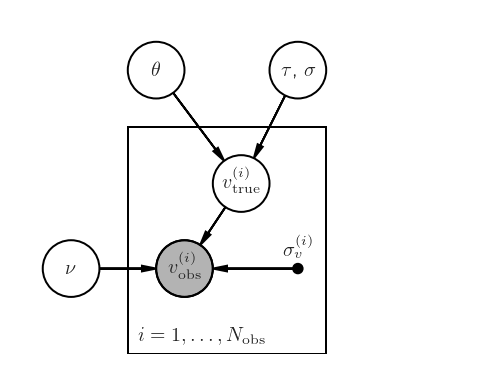

In [2]:
p = PGM((4,3))
p.add_node(Node("theta", r'$\theta$', 1.25, 2.5))
p.add_node(Node("tausigma", r'$\tau$, $\sigma$', 2.5, 2.5))
p.add_node(Node("rvtrue", r'$v_\mathrm{true}^{(i)}$', 2.0, 1.5))
p.add_node(Node("rvobs", r'$v_\mathrm{obs}^{(i)}$', 1.5, 0.75, observed=True))
p.add_node(Node("obserr", r'$\sigma_v^{(i)}$', 2.5, 0.75, fixed=True))
p.add_node(Node("errscale", r'$\nu$', 0.5, 0.75))
p.add_plate(Plate((1.0, 0.0, 1.75, 2.0), label=r'$i=1, \ldots, N_\mathrm{obs}$'))
p.add_edge("theta", "rvtrue")
p.add_edge("tausigma", "rvtrue")
p.add_edge("rvtrue", "rvobs")
p.add_edge("obserr", "rvobs")
p.add_edge("errscale", "rvobs")
p.render()
savefig('kepler-graphical.pdf')

Let's start by generating some data from the model by hand.  First, let's choose some true parameters for the RV signal.  We will choose a planet with a 15-day orbit, with a RV semi-amplitude $K = 10 \, \mpers$.  We give the planet a relatively large eccentricity, $e = 0.6$, so that the higher harmonics of the orbital frequency are important in the fit.  To avoid any commensurabilities, we add small random perturbations to the period.

In [3]:
Ptrue = 15 + rand() # d
Ktrue = 10.0 # m/s
etrue = 0.7
chitrue = rand()
omegatrue = random.uniform(low=0, high=2*pi)
mutrue = 5*rand() # m/s

Here is what the RV signal from the planet looks like at dense sampling.

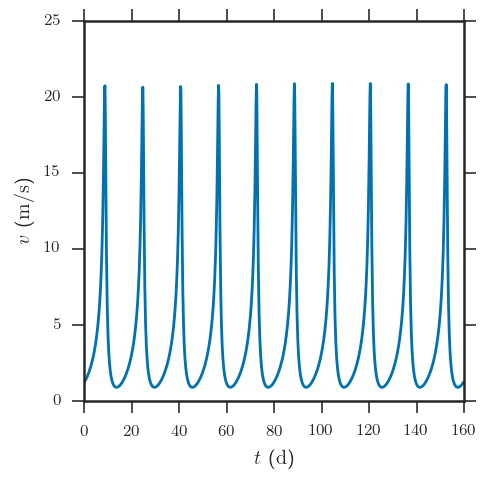

In [4]:
ts = Ptrue*linspace(0, 10, 1000)
rvtrue = rv.rv_model(ts, Ktrue, etrue, omegatrue, chitrue, Ptrue) + mutrue
plot(ts, rvtrue)
xlabel(r'$t$ ($\mathrm{d}$)')
ylabel(r'$v$ ($\mathrm{m}/\mathrm{s}$)')

Now let's discuss the sample rate for an actual survey.  Let us suppose that we want to sample about 150 days (nearly ten orbits).  Let us suppose that we take one measurement every two hours (so twelve a day, several hundred per orbit, ideally), with a 30-minute scatter.  Every twelve hours the sun comes up, and we cannot take measurements for the next twelve hours.  Additionally, a random 30% of our night-time measurements are "cloudy" and therefore eliminated.  So, we end up sampling at the following times:

In [5]:
ts = arange(0, 150, 1.0/12.0) # Sample every two hours 
ts += 1.0/48.0*(rand(ts.shape[0]) - 0.5) # Jitter the samples by 30 minutes
ts = ts[ts % 1 < 0.5] # We cannot observe in the second half of each day
ts = ts[rand(ts.shape[0]) < 0.7] # Throw away 30% of the samples
print ts.shape[0]

635


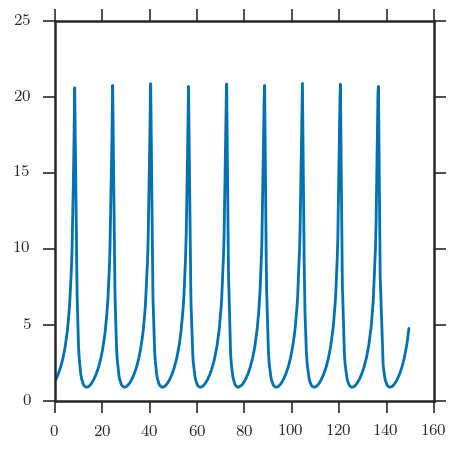

In [6]:
rvkepler = rv.rv_model(ts, Ktrue, etrue, omegatrue, chitrue, Ptrue) + mutrue
plot(ts, rvkepler)

Now we choose parameters for the stochastic RV component: because we want to be perverse, we choose the timescale in the GP to be 1.5 times shorter than the orbit, so the scale of the GP lies between the first and second harmonic of the orbit (we excite lots of these harmonics due to the relatively large eccentricity of the orbit).  We choose an amplitude for the Gaussian process that is comparable to the RV amplitude for the orbit.  We plot the resulting true RVs below.

In [34]:
tautrue = Ptrue/1.5 + 0.6*rand()
sigmatrue = Ktrue/2

Here we have to add a small white noise (digaonal covariance) component so that the covariance matrix is well-behaved.

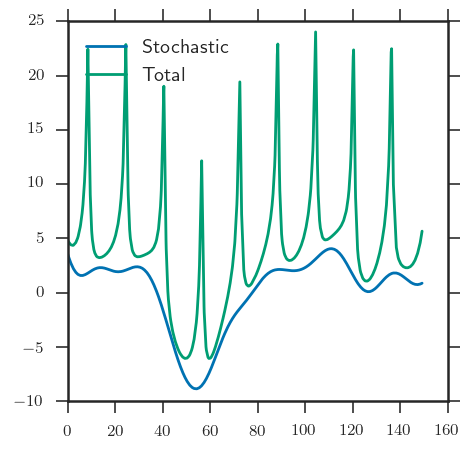

In [35]:
rvstochastic = random.multivariate_normal(zeros_like(ts), 1e-8*eye(ts.shape[0]) + cl.generate_covariance(ts, sigmatrue, tautrue))
rvtrue = rvkepler + rvstochastic
plot(ts, rvstochastic, label='Stochastic')
plot(ts, rvtrue, label='Total')
legend(loc='upper left')

Now we observe the data.  Let's assume that we observe each observation with an uncertainty that is between $\frac{1}{2}K_\mathrm{true}$ and $2 K_\mathrm{true}$, and then we uniformly under-estimate our "errorbars" by a factor of two.  We "observe" the RVs by adding random Gaussian noise.

In [78]:
nutrue = 2.0
dvs = Ktrue*random.uniform(low=0.5, high=2.0, size=ts.shape[0])
rvobs = rvtrue + dvs*randn(ts.shape[0])
dvs /= nutrue

Here is a plot of the observations.  The SNR of our RV signal is quite large, and we will see that the fit comes out quite well.  Because of the above code, the quoted measurement uncertainties below are a factor of two smaller than the actual measurements uncertainties.

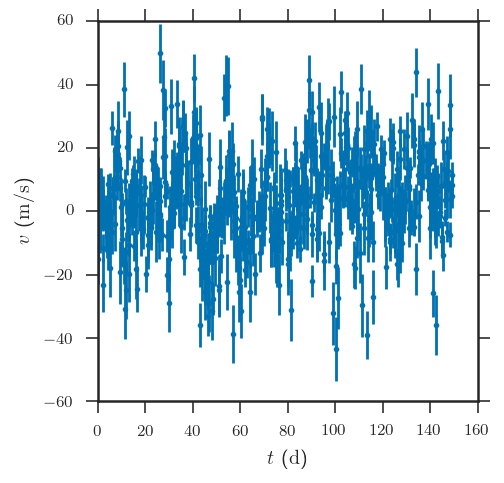

In [79]:
errorbar(ts, rvobs, dvs, fmt='.')
xlabel(r'$t$ ($\mathrm{d}$)')
ylabel(r'$v$ ($\mathrm{m}/\mathrm{s}$)')

Now we set up a posterior object, and make an initial set of walkers that are widely dispersed:

In [80]:
print(cl.params_dtype)
ptrue = array([mutrue, Ktrue, etrue, omegatrue, chitrue, Ptrue, nutrue, sigmatrue, tautrue])
post = cl.Log1PPosterior(ts, rvobs, dvs)
print(post(ptrue))

[('mu', '<f8'), ('K', '<f8'), ('e', '<f8'), ('omega', '<f8'), ('chi', '<f8'), ('P', '<f8'), ('nu', '<f8'), ('sigma', '<f8'), ('tau', '<f8')]
-2471.11172291


We are going to cheat on the distribution so we can illustrate the sampling without having to worry about searching, particularly over period which complicates any RV analysis significantly.  Let's initialise very close to the true parameters:

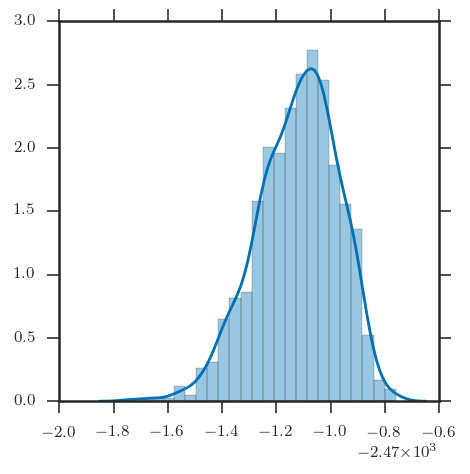

In [81]:
init = ptrue + 1e-3*randn(1024, 9)
sns.distplot(array([post(init[i,:]) for i in range(1024)]))

We would like to follow the convergence to constant acceptance rate, so let's create a callback function that plots the accetpance fraction by step.  We will also plot the mean value of the log-posterior, and indicate the value at the true parameters.

In [86]:
def cb(samplr):
    f1 = figure(1)
    clf()
    plot(samplr.acceptance_fraction)

    f2 = figure(2)
    clf()
    plot(mean(samplr.lnpost, axis=1))
    lnprob_true = post(ptrue)
    axhline(lnprob_true)

    f3 = figure(3)
    clf()
    nd = samplr.chain.shape[2]
    n = int(ceil(sqrt(nd)))
    for i in range(nd):
        subplot(n,n,i+1)
        for j in range(samplr.chain.shape[1]):
            plot(samplr.chain[:,j,i])
        axhline(ptrue[i], color='k')

    display.clear_output(wait=True)
    display.display(f1)
    display.display(f2)
    display.display(f3)

We begin by burning in the sampler, which will take the over-dispersed array of initial points, and begin moving it around.  It will tend to converge toward the peak of the posterior function; as the walkers move far from the initial distribution that was used to initialise the proposal, the acceptance rate will fall.  The burnin function detects this, and will re-initialise the proposal to the new positions and continue the run.  Burnin ends when the acceptance rate stabilises.

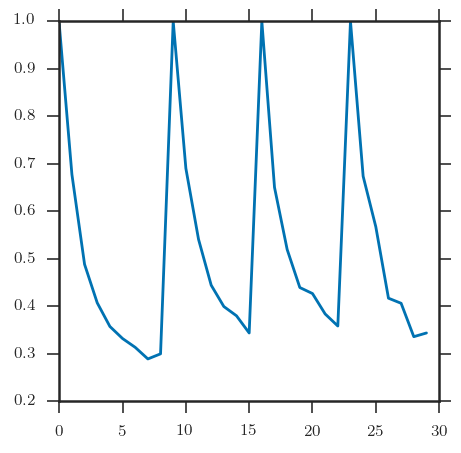

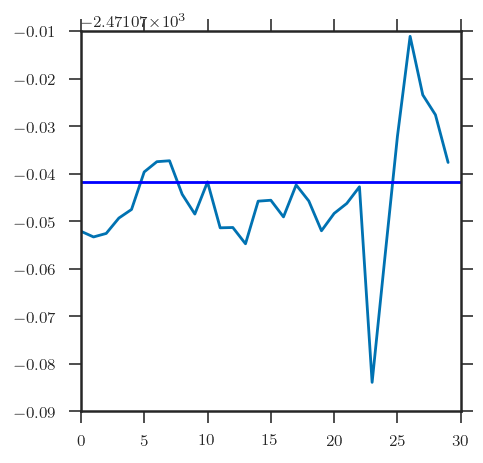

KeyboardInterrupt: 

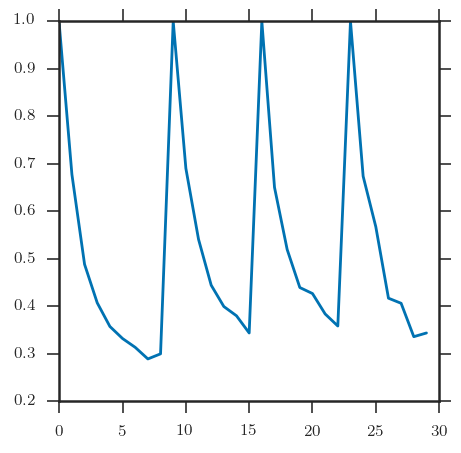

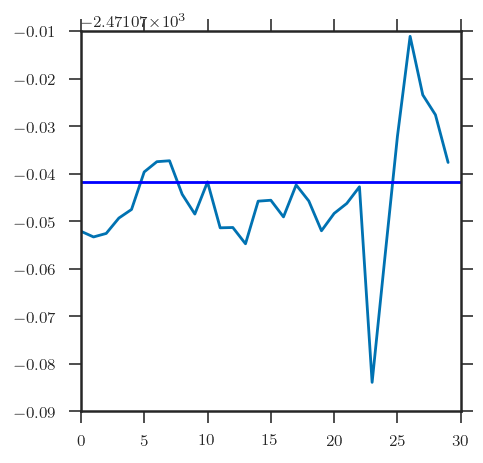

In [83]:
sampler = kombine.Sampler(Nwalkers, ptrue.shape[0], post)
sampler.burnin(p0=init, callback=cb)

Whew!  That took a while.  Let's take advantage of our keyboard interrupt to take a look at the evolution of the chains; then we can go back to burnin if we want.  Run the cell below when you want to resume burnin (remember not to provide a `p0` argument, or you will reset the burnin!).

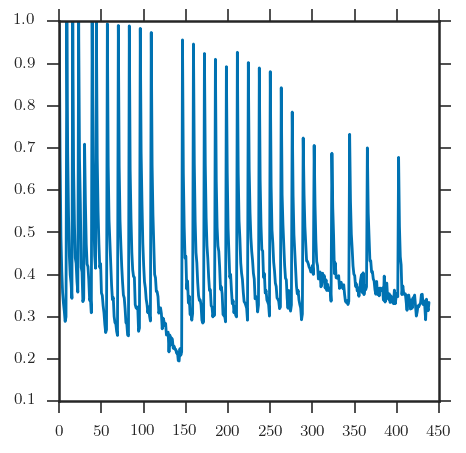

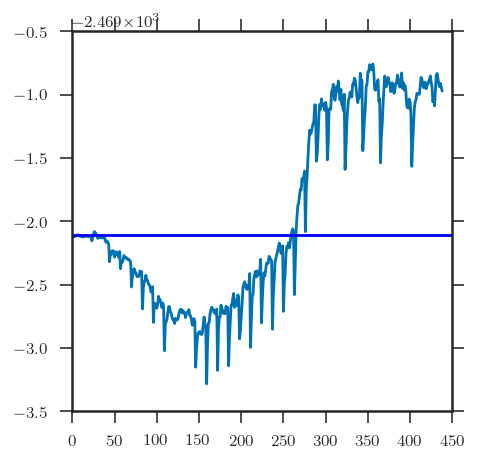

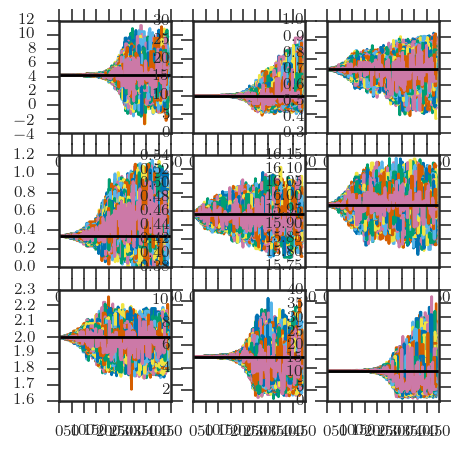

(array([[  4.20025927,  10.71747553,   0.6755035 , ...,   1.92149276,
           4.31796971,   4.73389981],
        [  4.68113157,   8.80366344,   0.7375604 , ...,   1.97002288,
           2.85036934,   6.03901417],
        [  3.92808253,   9.95054249,   0.71632783, ...,   1.98393791,
           4.14975301,  17.10955764],
        ..., 
        [  5.90409837,  15.8768731 ,   0.82179836, ...,   2.08233275,
           3.10121105,   5.95000644],
        [  6.22984158,   6.92945035,   0.69284536, ...,   1.9263167 ,
           7.39741438,   6.00613836],
        [  5.36009233,   9.13513616,   0.62495766, ...,   2.00233038,
           4.13764108,   4.24471785]]),
 array([-2466.78216993, -2473.14873534, -2473.02945296, ..., -2469.88839991,
        -2474.81322668, -2467.48884816]),
 array([ 4.33944324, -2.94709479, -1.04043816, ..., -0.01383684,
        -3.40031979,  3.55698227]))

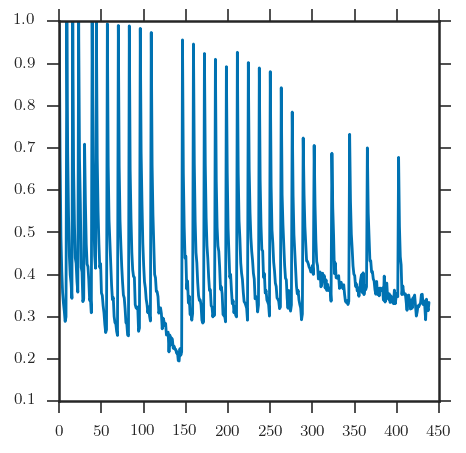

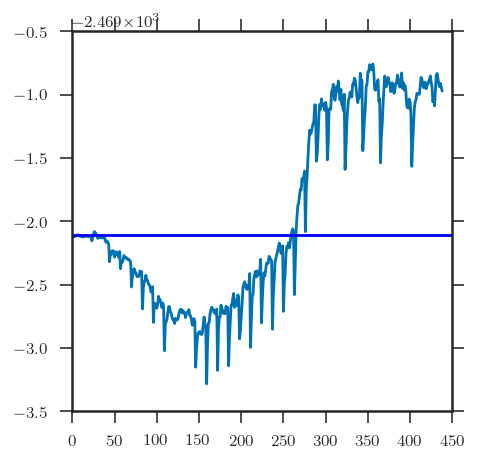

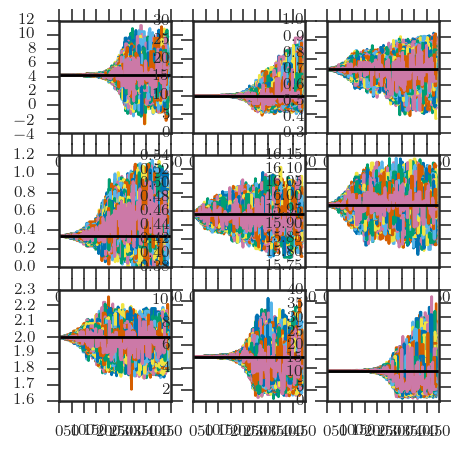

In [87]:
sampler.burnin(callback=cb)

The spikes in the acceptance rate (top plot) occur every time we update the KDE proposal because the new proposal is finely tuned to the current positions of the walker, and therefore the probability of a return jump to that location is high in the Metropolis-Hastings acceptance probability.  Similarly, the downward spikes in the ensemble mean posterior (bottom plot) occur because this high proposal density factor in the acceptance rate permits jumps to smaller posterior values.  After a couple of steps, the ensemble has randomised and the acceptance rate and mean log posterior equilibrate.

Let's have a look at the final result:

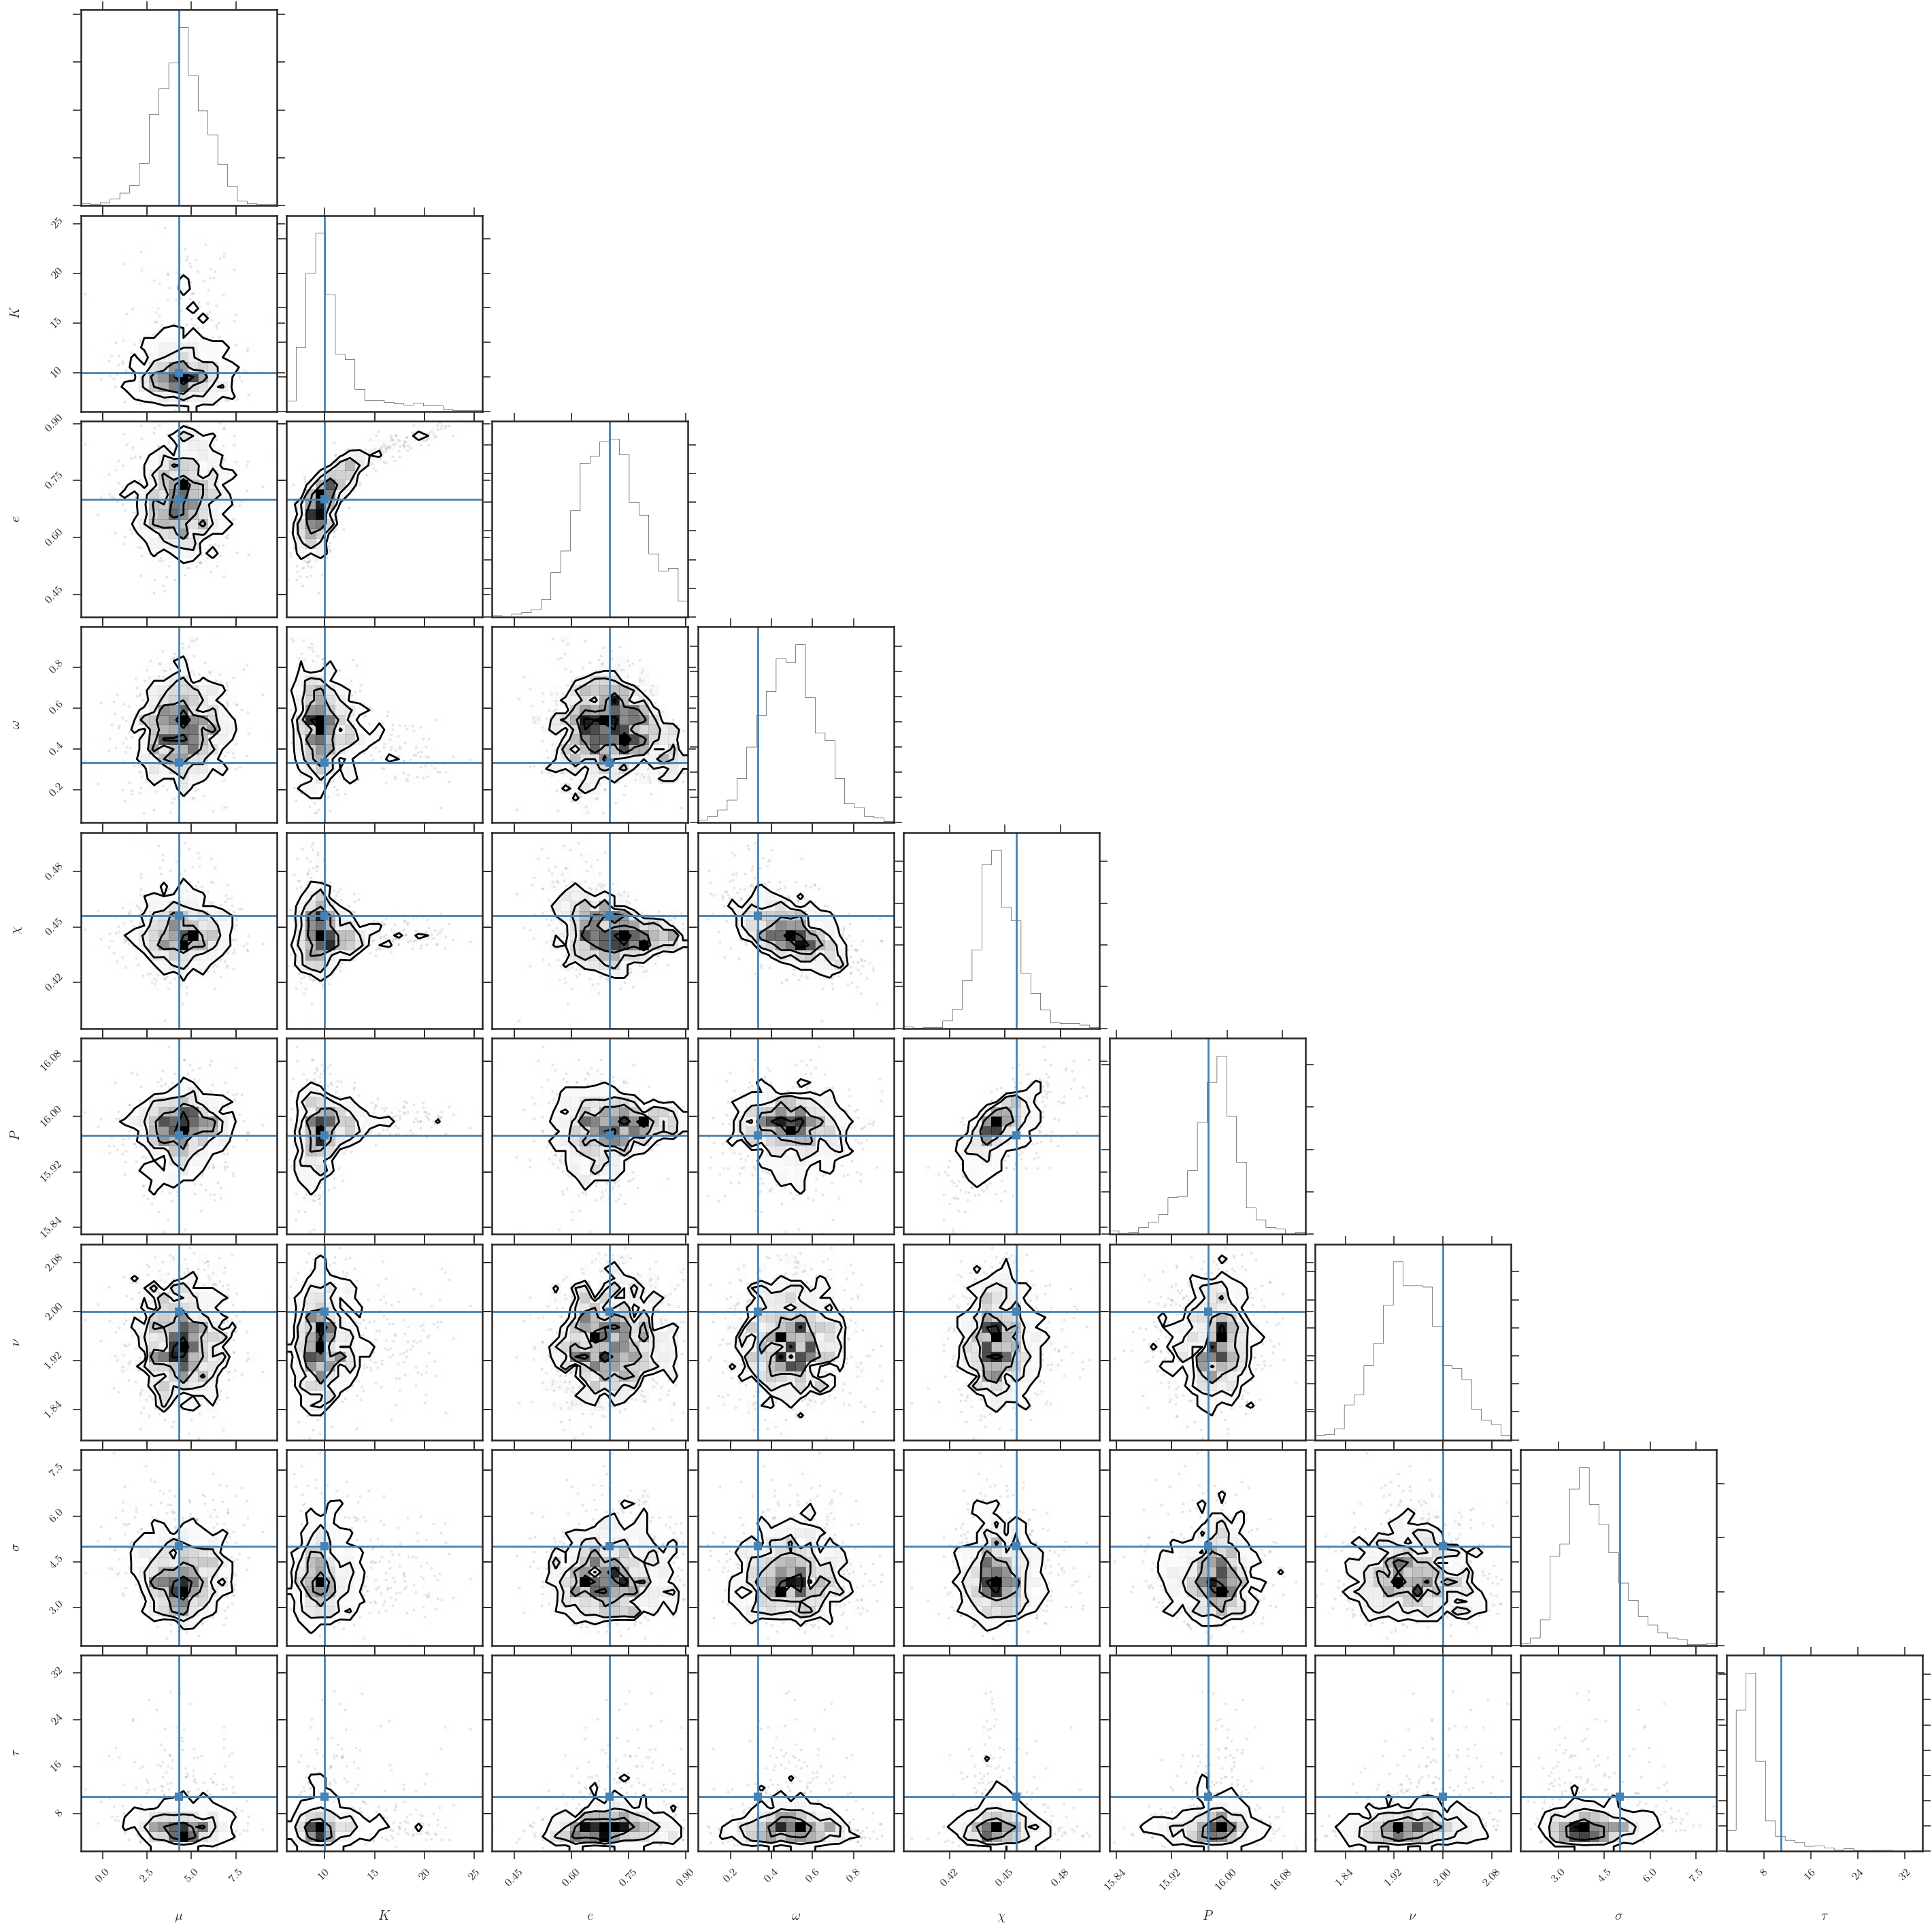

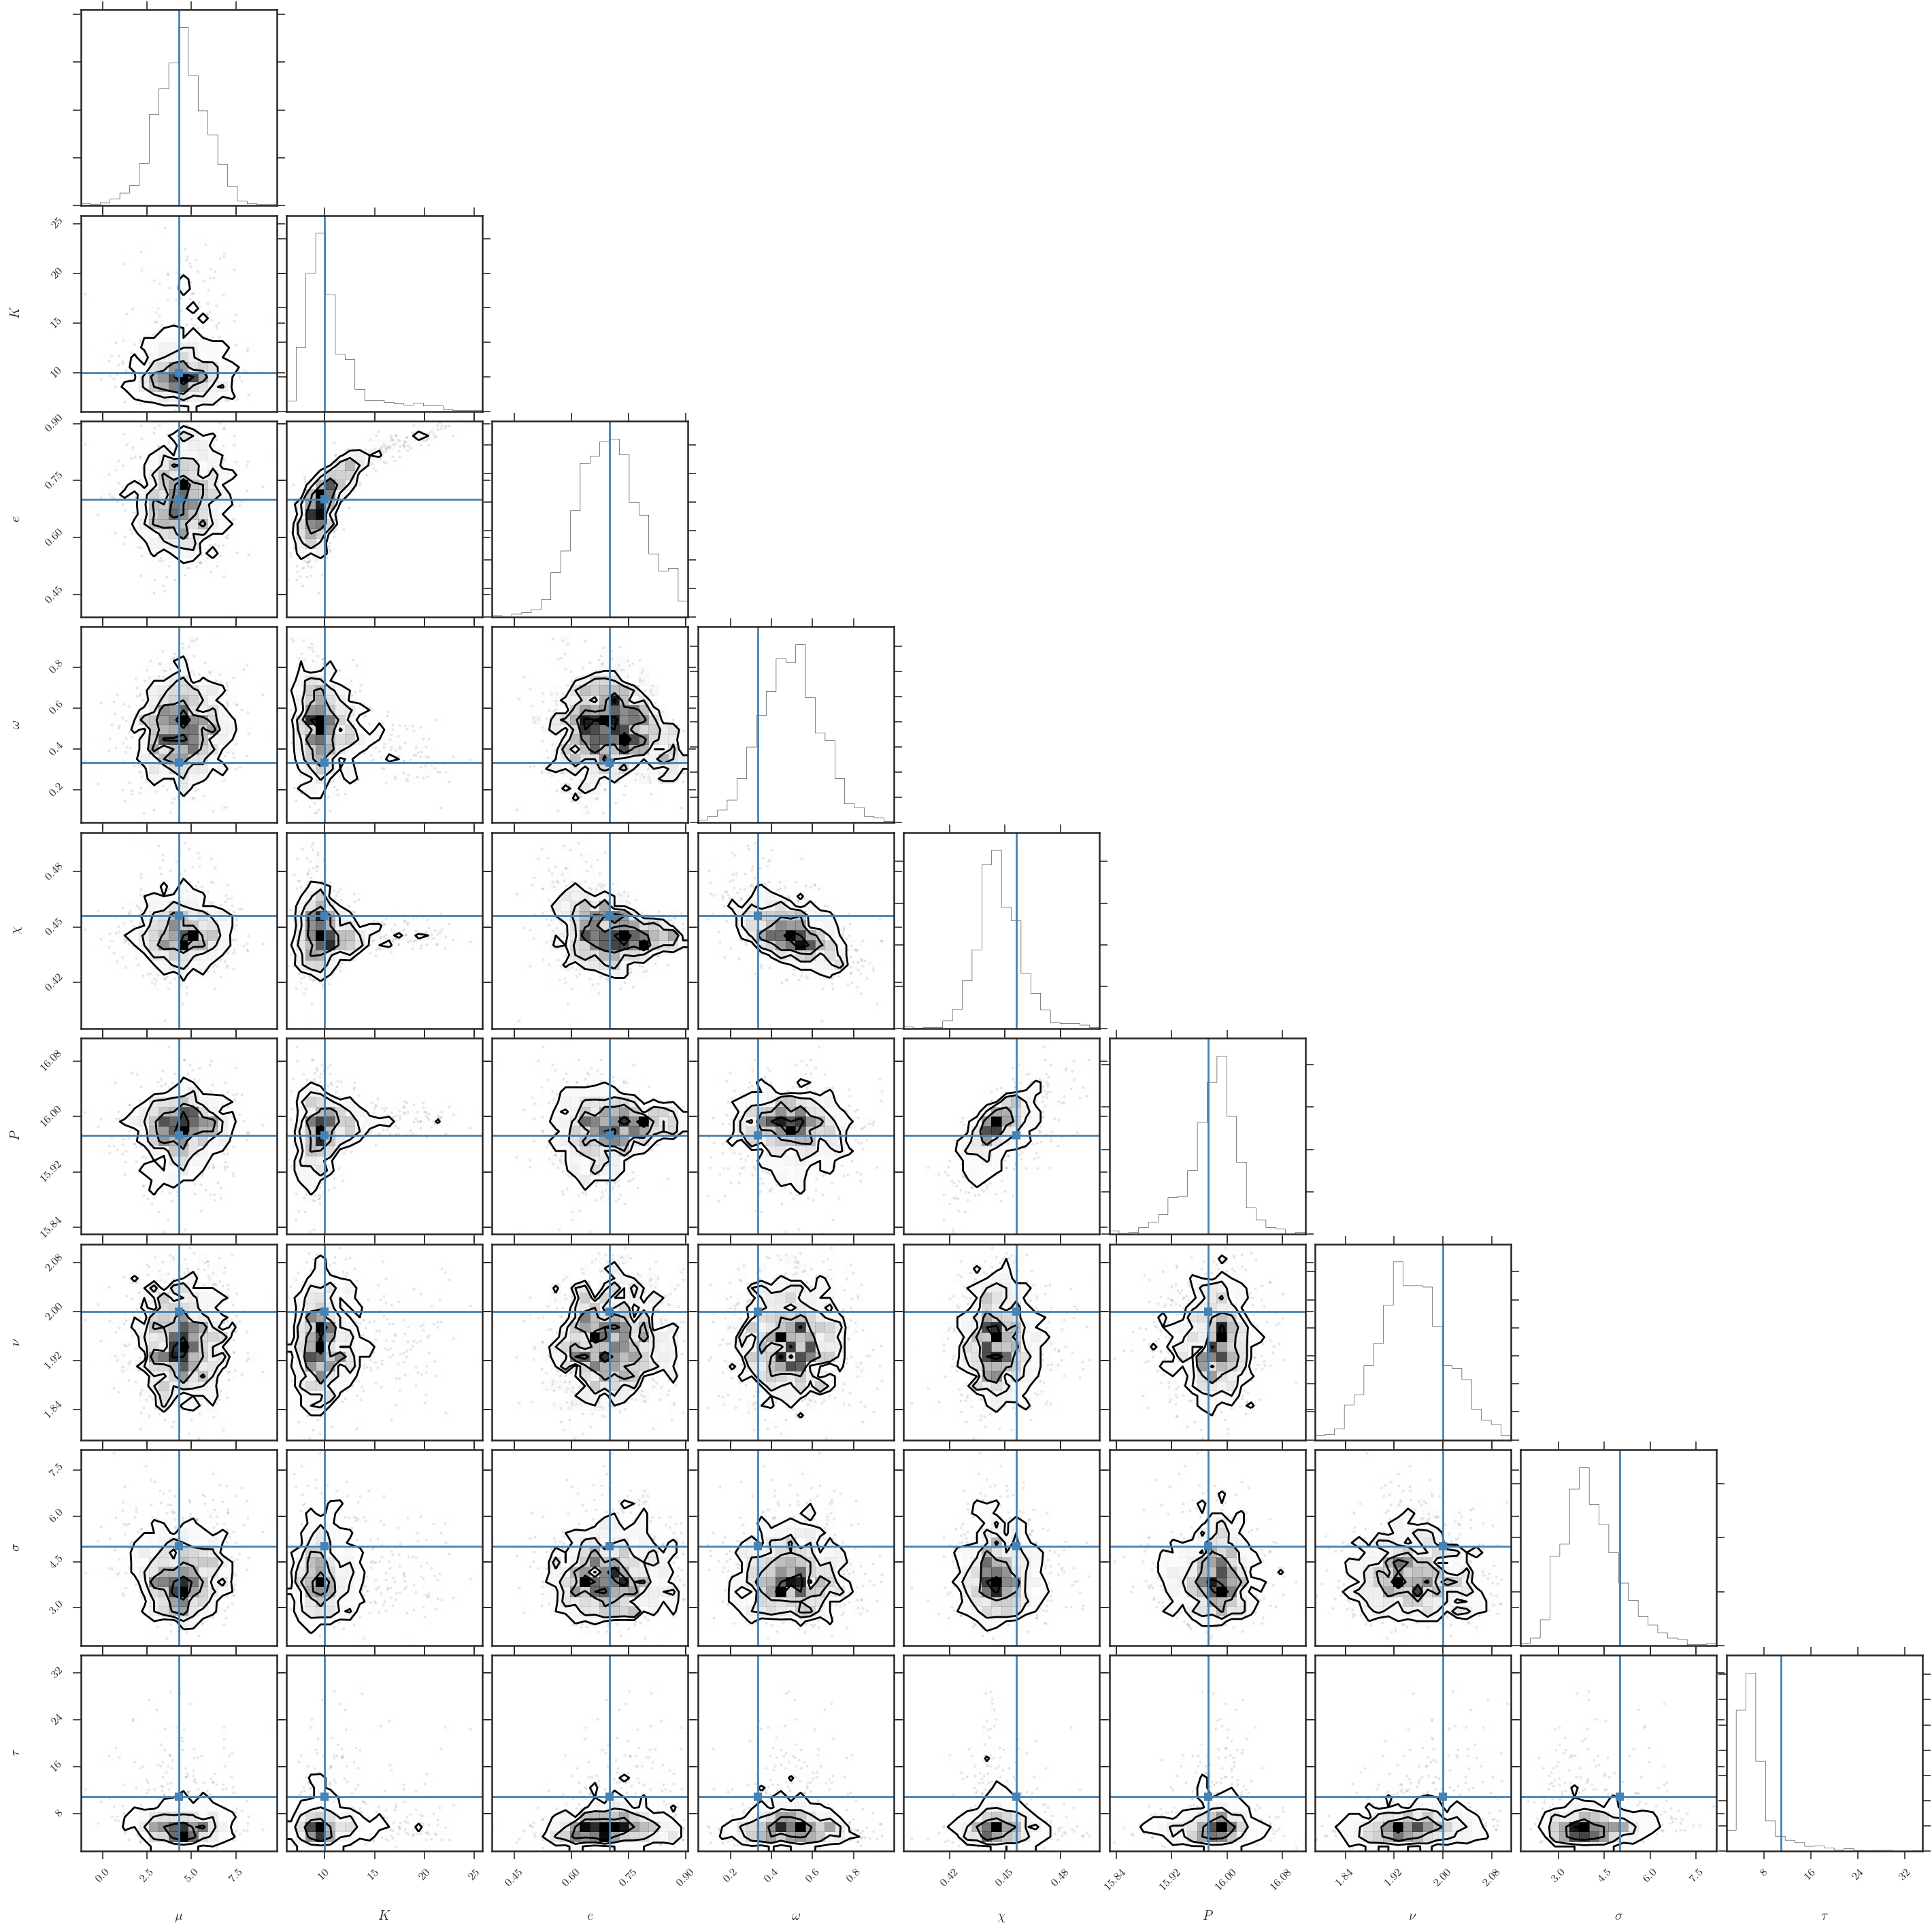

In [88]:
corner.corner(sampler.chain[-1,:,:], truths=ptrue, labels=[r'$\mu$', r'$K$', r'$e$', r'$\omega$', r'$\chi$', r'$P$', r'$\nu$', r'$\sigma$', r'$\tau$'])

These posteriors look sort of ratty.  Let's run the sampler for 10 ACL's, and thereby accumulate a lot more points.  Recall that the theoretical ACL is 
$$
\tau = \frac{2}{f} - 1
$$
for an acceptance rate of $f$, so:

In [89]:
acl = 2.0/sampler.acceptance_fraction[-1] - 1
nstep = int(ceil(10*acl))
print('10*tau = {:g}'.format(10*acl))

10*tau = 49.883


In [90]:
result = sampler.run_mcmc(nstep)

Note that we just drew O(10k) independent samples from our distribution in a few minutes once we burned in.  Check that the sampling was converged by looking at the acceptance rate:

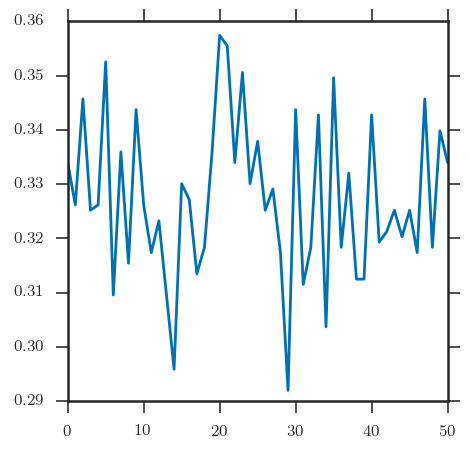

In [91]:
plot(sampler.acceptance_fraction[-(nstep+1):])

Now let's make the corner plot from the last 10 ACL's worth of samples:

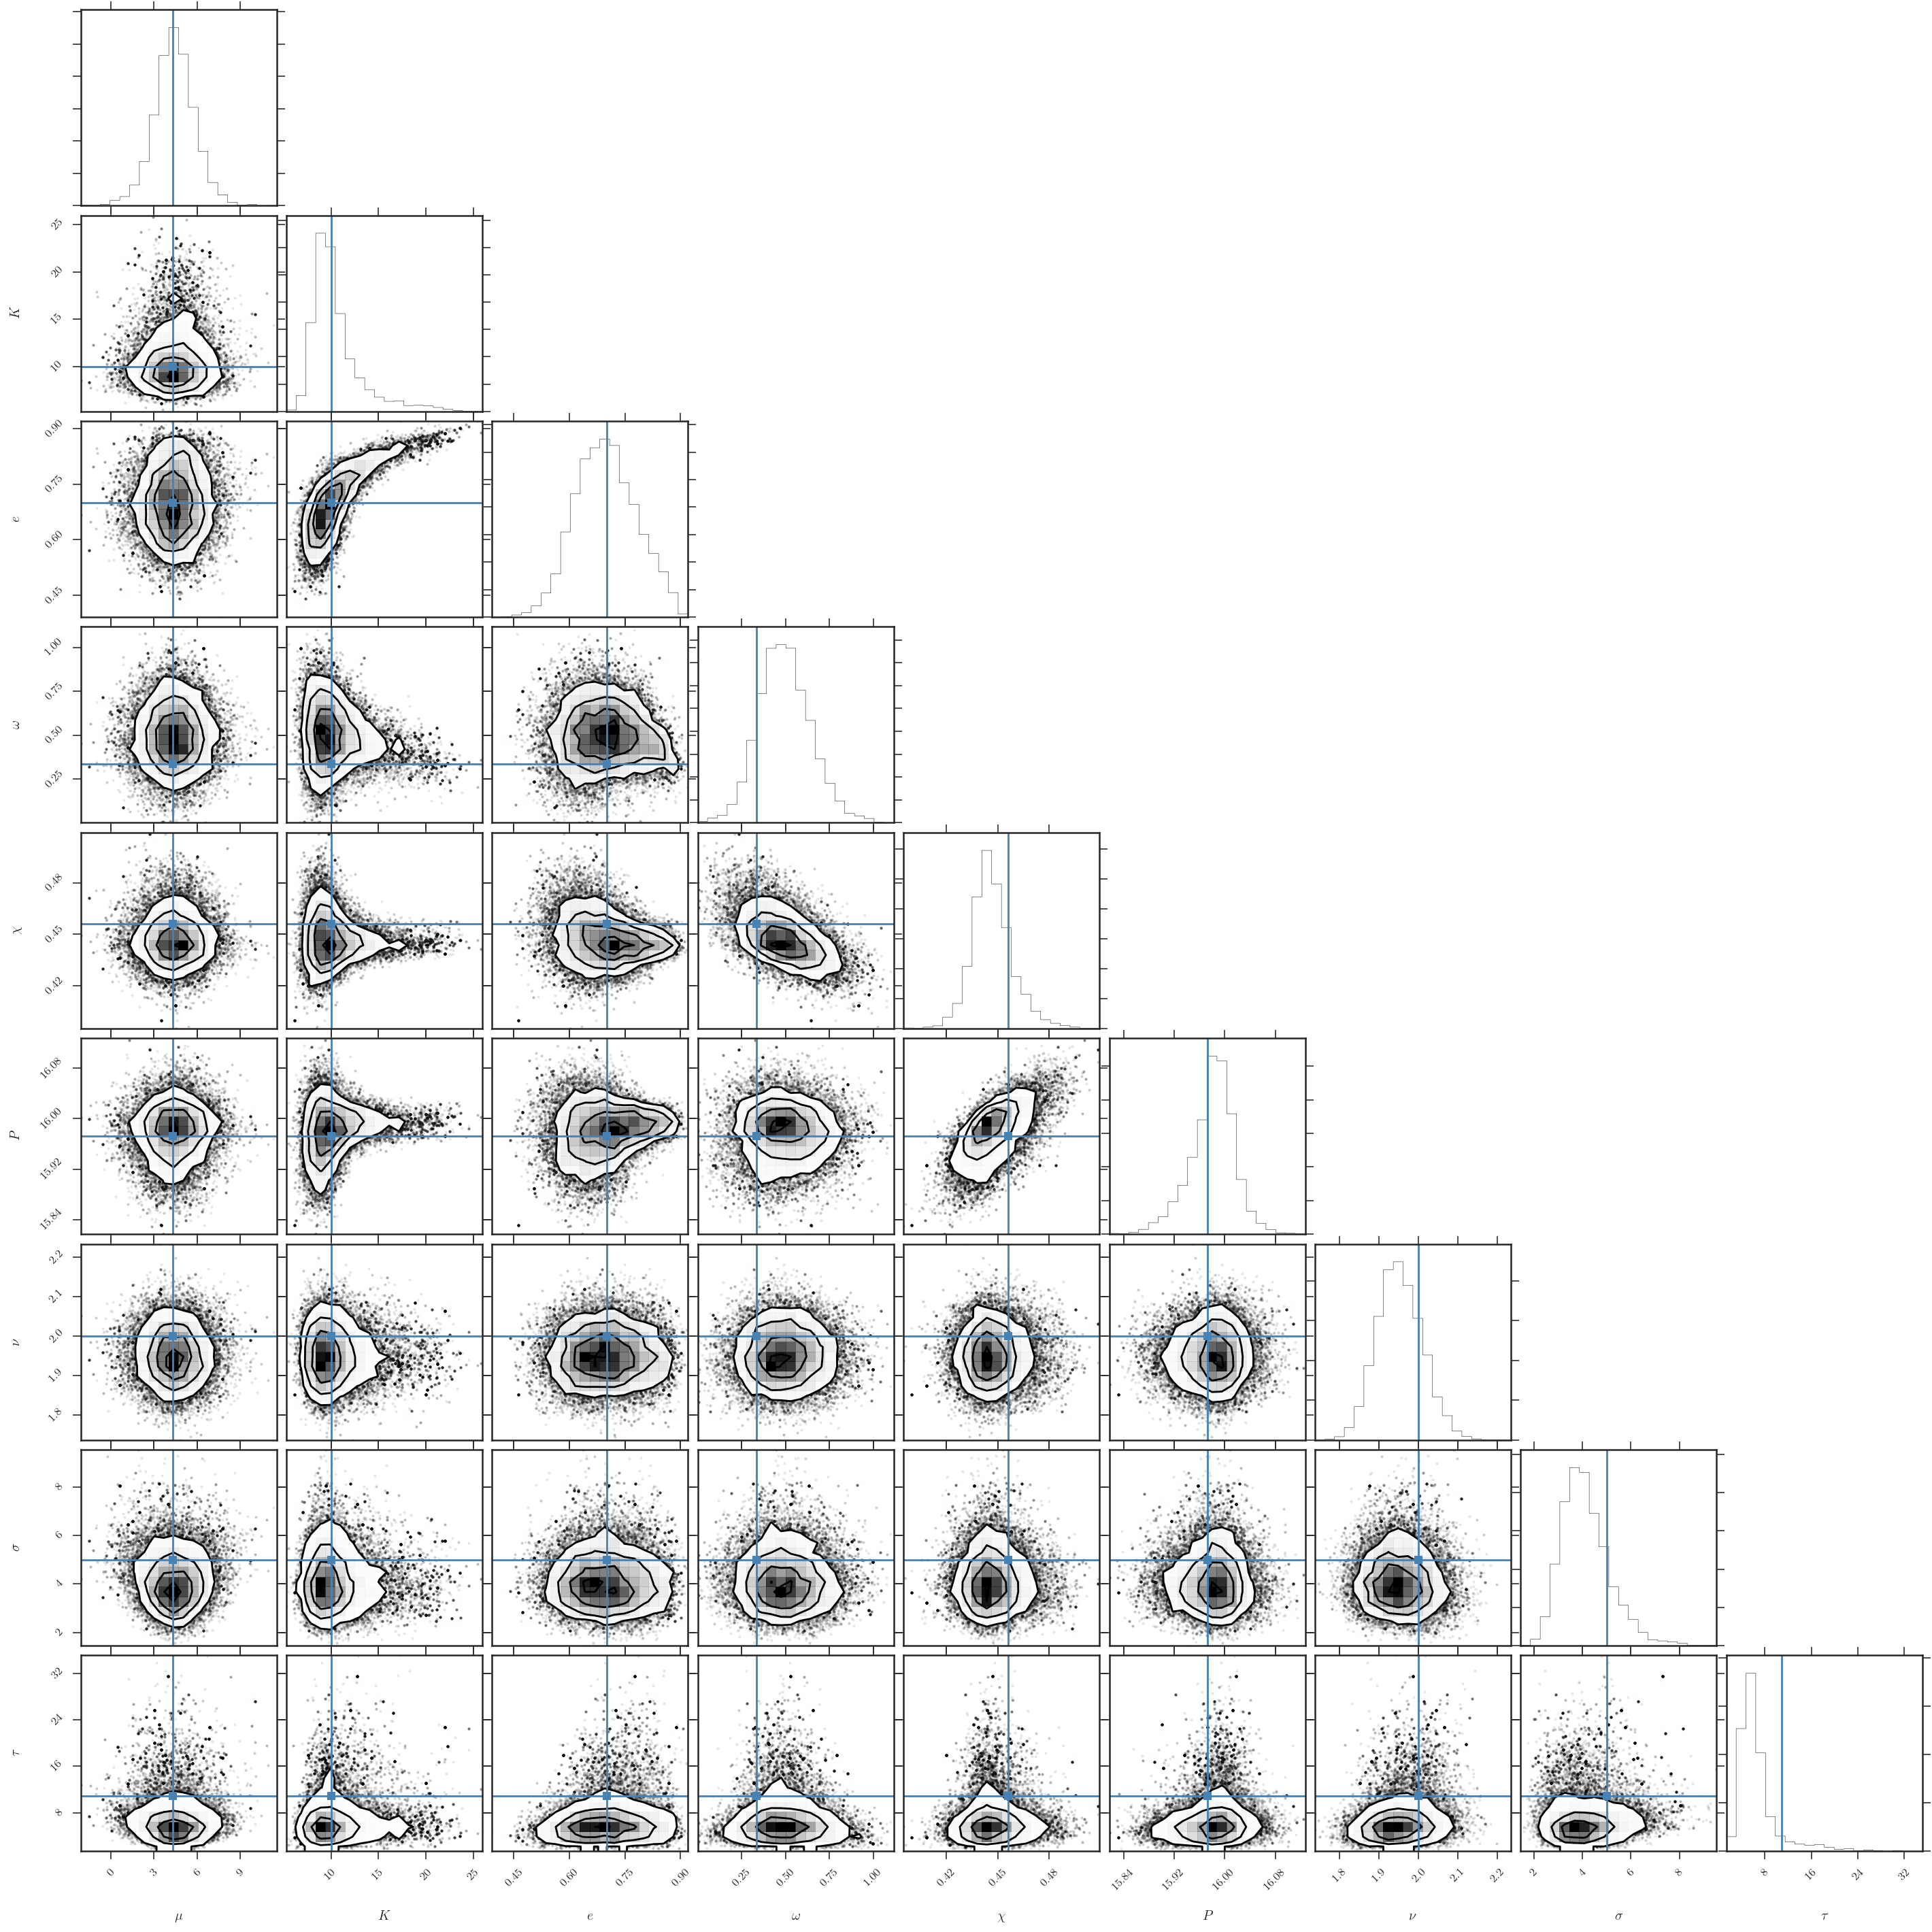

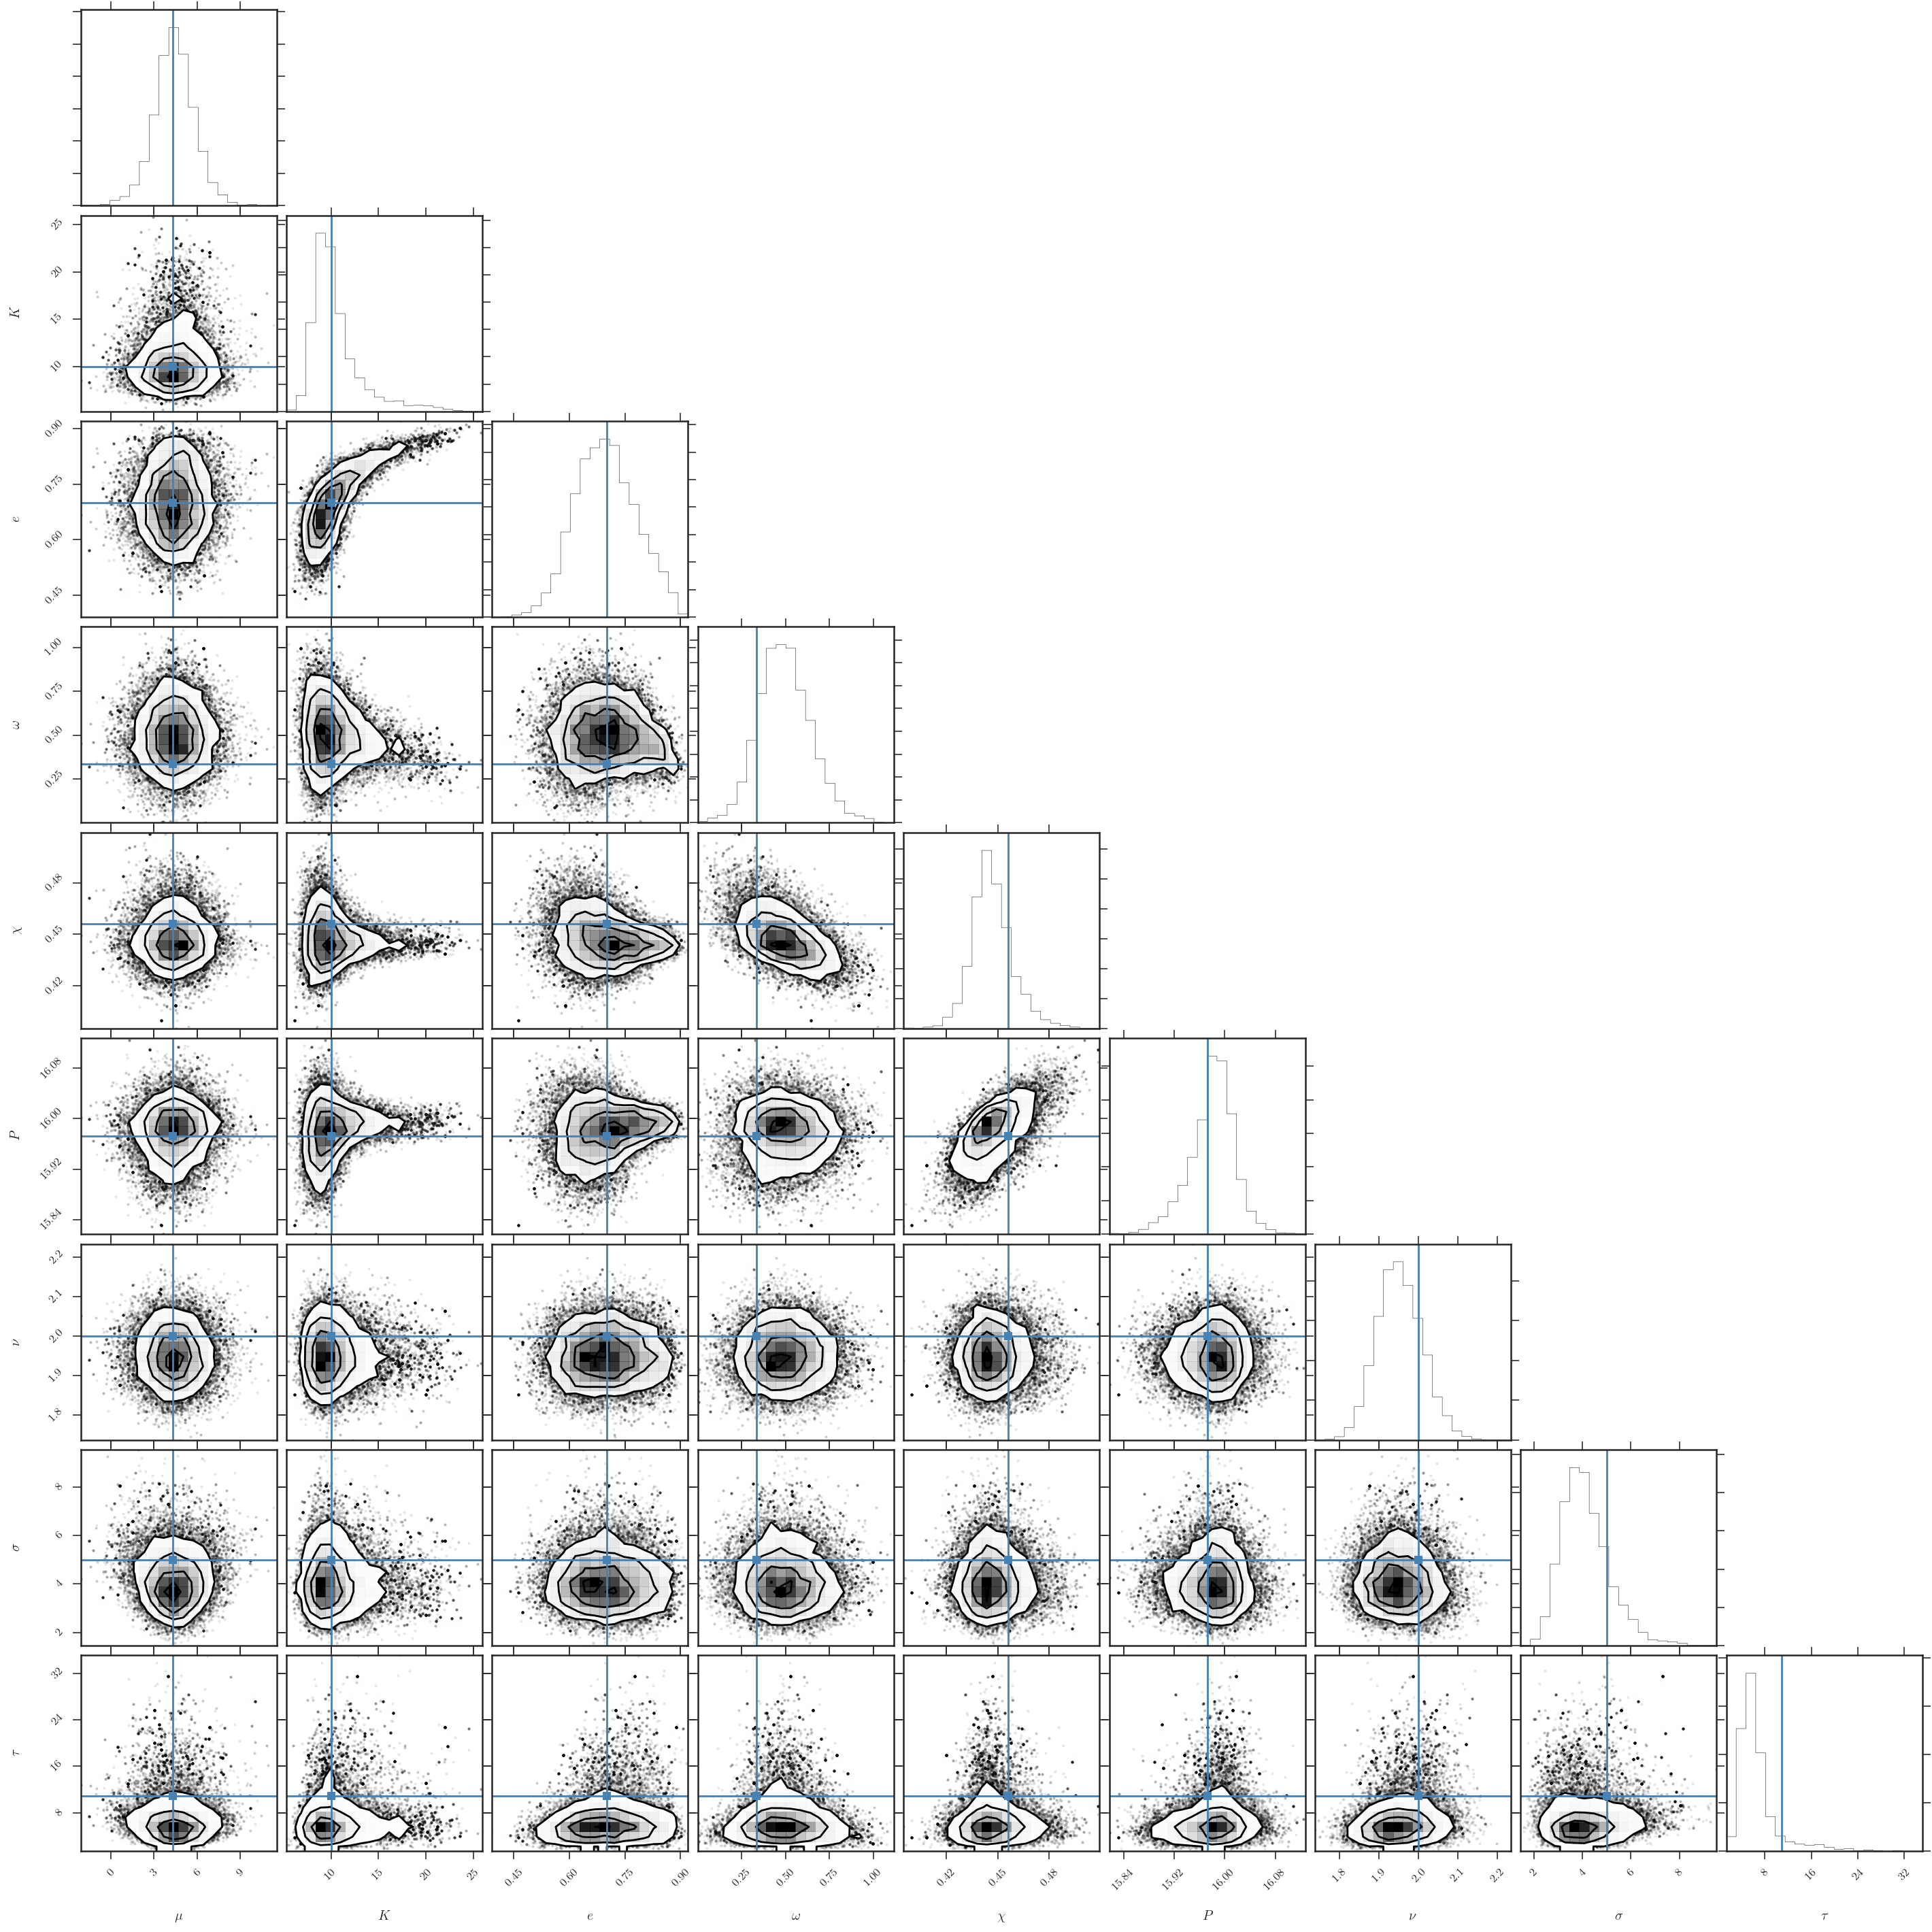

In [92]:
corner.corner(reshape(sampler.chain[-(nstep+1):,:,:], (-1, sampler.chain.shape[2])), truths=ptrue, labels=[r'$\mu$', r'$K$', r'$e$', r'$\omega$', r'$\chi$', r'$P$', r'$\nu$', r'$\sigma$', r'$\tau$'])

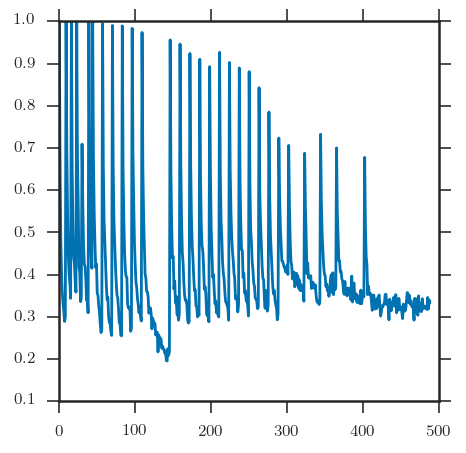

In [105]:
plot(sampler.acceptance_fraction)

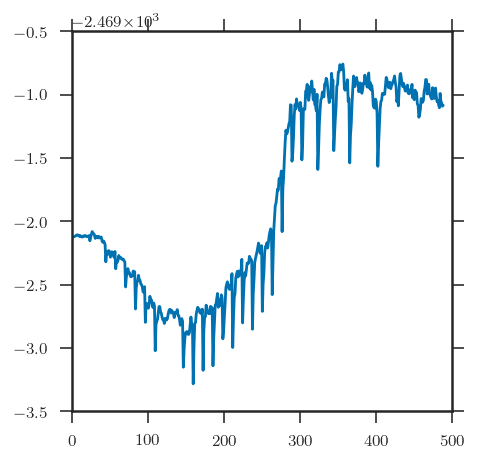

In [106]:
plot(mean(sampler.lnpost, axis=1))

Here we save the final state of the chain and the data---so you can resume the sampling if you want to play around.  Please note that the above code does not set the random seed, so you will need to re-load the data associated with this chain, not re-generate it above.

In [110]:
with open("rvs.dat", "w") as out:
    out.write("t\tv\tdv\n")
    savetxt(out, column_stack((ts, rvobs, dvs)))
savetxt("chain-state.dat", sampler.chain[-1,:,:])